In [1]:
%matplotlib notebook
# build a simple rnn with cleaned test data to predict stock rice 
# 将股票涨幅看作分类问题

# step1: import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from sklearn import datasets
import matplotlib.pyplot as plt
import os
import math

path = './test_data/'
stock_code = '600000'
filename = 'cleaned'+stock_code+'.csv'
df = pd.read_csv(path+filename)

In [2]:
def rise_label(r):
    if r > 0.06:
        return 3
    elif r > 0.03:
        return 2
    elif r > 0:
        return 1
    else:
        return 0
df['rise_label'] = df['rise'].apply(lambda x: rise_label(x))


In [3]:
# step2: 制定训练集和测试集
# 总数据集大小
data_sz = df.shape[0]
# 计算测试集大小, 约为原数据的%20. 向上取整
test_set_sz = math.ceil(data_sz * 0.2)
training_set_sz = data_sz - test_set_sz
# 前(data_sz - test_set_sz)天的涨幅作为训练集, 后test_set_sz天的涨幅作为测试集
training_set = df.iloc[0:training_set_sz, 2:3].values
training_label = df.iloc[0:training_set_sz, 3:4].values
test_set = df.iloc[-test_set_sz:, 2:3].values
test_label = df.iloc[-test_set_sz:, 3:4].values

In [4]:
x_train = []
y_train = []

x_test = []
y_test = []
sample_sz = 15

In [5]:
for i in range(sample_sz, training_set_sz):
    x_train.append(training_set[i - sample_sz:i, 0])
    y_train.append(training_label[i, 0])

In [6]:
# 对训练集进行打乱
np.random.seed(56)
np.random.shuffle(x_train)
np.random.seed(56)
np.random.shuffle(y_train)
tf.random.set_seed(56)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
for i in range(sample_sz, test_set_sz):
    x_test.append(test_set[i - sample_sz:i, 0])
    y_test.append(test_label[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [8]:
class StockModel(Model):
    def __init__(self):
        super(StockModel, self).__init__()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, x):
        x = self.d1(x)
        y = self.d2(x)
        return y

model = StockModel()

In [12]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/stock_rice_pred_DNN.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                   callbacks=[cp_callback])
model.summary()

file = open('./weights/stock_rice_pred_DNN_weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

-------------load the model-----------------
Train on 187 samples, validate on 36 samples
Epoch 1/50
187/187 [==============================] - 0s 2ms/sample - loss: 0.8923 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1317 - val_sparse_categorical_accuracy: 0.4444
Epoch 2/50
187/187 [==============================] - 0s 382us/sample - loss: 0.8667 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1407 - val_sparse_categorical_accuracy: 0.4444
Epoch 3/50
187/187 [==============================] - 0s 249us/sample - loss: 0.8515 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1500 - val_sparse_categorical_accuracy: 0.4444
Epoch 4/50
187/187 [==============================] - 0s 268us/sample - loss: 0.8413 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1516 - val_sparse_categorical_accuracy: 0.4444
Epoch 5/50
187/187 [==============================] - 0s 254us/sample - loss: 0.8332 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1489 - val_sparse_categorical_accuracy:

Epoch 45/50
187/187 [==============================] - 0s 542us/sample - loss: 0.7756 - sparse_categorical_accuracy: 0.5775 - val_loss: 1.1643 - val_sparse_categorical_accuracy: 0.4444
Epoch 46/50
187/187 [==============================] - 0s 273us/sample - loss: 0.7678 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1795 - val_sparse_categorical_accuracy: 0.4444
Epoch 47/50
187/187 [==============================] - 0s 225us/sample - loss: 0.7651 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1780 - val_sparse_categorical_accuracy: 0.4444
Epoch 48/50
187/187 [==============================] - 0s 366us/sample - loss: 0.7678 - sparse_categorical_accuracy: 0.5829 - val_loss: 1.1720 - val_sparse_categorical_accuracy: 0.4444
Epoch 49/50
187/187 [==============================] - 0s 334us/sample - loss: 0.7674 - sparse_categorical_accuracy: 0.5561 - val_loss: 1.1865 - val_sparse_categorical_accuracy: 0.4444
Epoch 50/50
187/187 [==============================] - 0s 350us/sample - lo

<IPython.core.display.Javascript object>


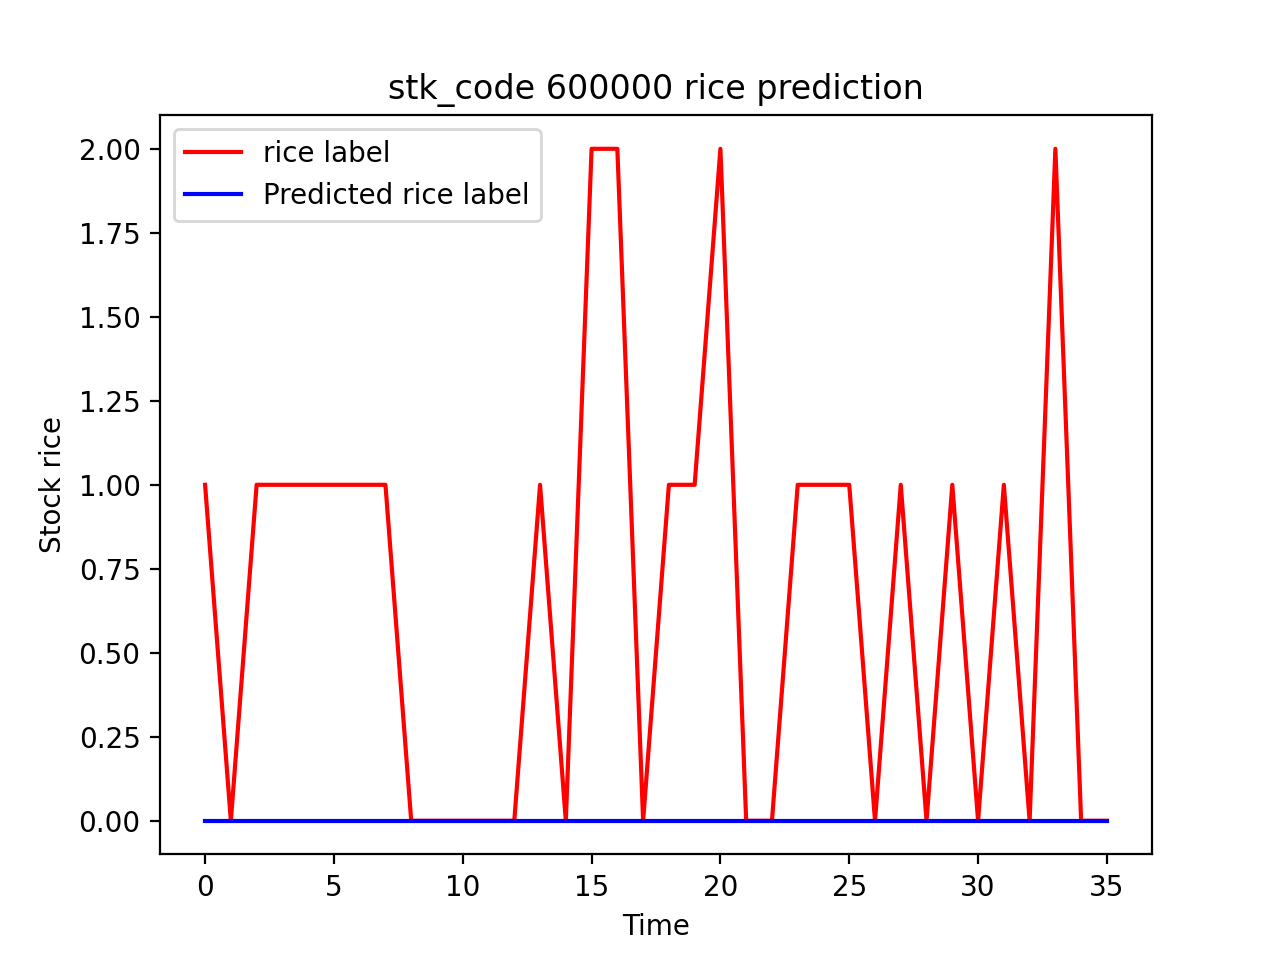

In [10]:
# 预测
# 测试集输入模型进行预测
predicted_stock_rice = model.predict(x_test)
pred = tf.argmax(predicted_stock_rice, axis=1)
real_stock_rice_label = test_label[sample_sz:]
# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_rice_label, color='red', label='rice label')
plt.plot(pred, color='blue', label='Predicted rice label')
plt.title('stk_code '+stock_code + ' rice prediction')
plt.xlabel('Time')
plt.ylabel('Stock rice')
plt.legend()
plt.show()

In [11]:
model.predict(x_test)

array([[0.5608443 , 0.41877237, 0.01031018, 0.01007305],
       [0.5511276 , 0.42722604, 0.01093203, 0.01071437],
       [0.5636725 , 0.41558734, 0.01049561, 0.01024463],
       [0.55831176, 0.4216121 , 0.01014938, 0.00992674],
       [0.5516727 , 0.42679983, 0.01087396, 0.01065352],
       [0.5576327 , 0.421042  , 0.01078175, 0.01054361],
       [0.5471709 , 0.4310891 , 0.01097315, 0.01076688],
       [0.5476666 , 0.42946354, 0.0115473 , 0.01132253],
       [0.55692756, 0.4219119 , 0.0106961 , 0.01046446],
       [0.53881776, 0.44012582, 0.01061488, 0.01044158],
       [0.5796339 , 0.40052608, 0.01006235, 0.00977777],
       [0.56282353, 0.41860777, 0.00939346, 0.00917521],
       [0.56363493, 0.41696447, 0.00981514, 0.00958547],
       [0.57163644, 0.40898535, 0.00981635, 0.00956187],
       [0.54331017, 0.4353239 , 0.01077976, 0.01058629],
       [0.5438202 , 0.43510625, 0.01063174, 0.0104418 ],
       [0.54334474, 0.43433604, 0.01126115, 0.01105799],
       [0.5474571 , 0.42884156,